In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Lab 3 Assignment
- In the exercises, you will still use the same dataset after One-Hot Encoding
- The dependent variable is "default payment next month"

__Name:__ ANSHUL BAIREDDY

## Starting point - Import and Split dataset
- Split the dataset into training and testing set, with a ratio of 80:20

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [2]:
df = pd.read_excel('http://fengmai.net//download/courses/2020S-BIA652NT-Pub/Week10-Classification%20and%20Hyperparameter%20Search%20using%20Python/default%20of%20credit%20card%20clients.xls', header = 1).drop('ID', axis = 1)

col = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df2 = pd.get_dummies(df, columns = col, drop_first=True)
df2.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,...,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [3]:
from sklearn.model_selection import train_test_split
y = df2['default payment next month'].values.astype(float)
x = df2.drop('default payment next month', axis = 1).values.astype(float)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

## Q1 - Grid-search both C and number of PCs 

Next, we use the gride search procedure to search for both the optimal C (inverse of L2 regularization parameter) and the number of principle components using cross validation on the train set.

- Define a parameter grid such that pca__n_components is 10 to 30, and add C as a parameter that can take the following values: [1000, 100, 10, 1, 0.1, 0.01]. Hint: use `pipe.get_params().keys()` to get the right key for C. 
- Which C and PC combination is the best?

In [5]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [14]:
##### YOUR CODE HERE ######
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# We need to get a pipeline 
pipe = Pipeline([
    ('standardization', preprocessing.StandardScaler()),
    ('pca', PCA()),    
    ('lg', LogisticRegression(solver ='lbfgs', max_iter = 1000))
])
param_grid = {
  'lg__C': [1000, 100, 10, 1, 0.1, 0.01],
  'pca__n_components':  range(10, 30)
}
# using cross validation we get 
grid = GridSearchCV(pipe, cv = 3, param_grid = param_grid, scoring = 'roc_auc', refit=True, verbose=1)
grid_fit = grid.fit(x_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [15]:
report(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.764 (std: 0.007)
Parameters: {'lg__C': 1, 'pca__n_components': 28}

Model with rank: 2
Mean validation score: 0.764 (std: 0.006)
Parameters: {'lg__C': 1000, 'pca__n_components': 29}

Model with rank: 3
Mean validation score: 0.764 (std: 0.007)
Parameters: {'lg__C': 10, 'pca__n_components': 28}



## Q2 - Provide AUC in the test set
- Based on Q1, use the best chosen model to provide AUC for the test set

AUC: 0.76


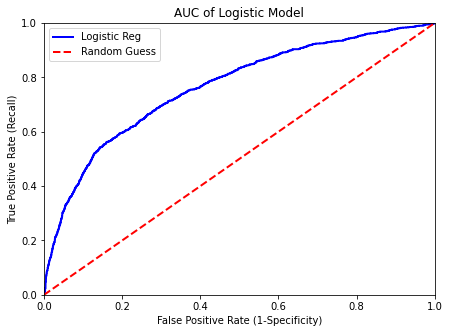

In [9]:
#### YOUR CODE HERE ####
inal_model = grid.best_estimator_


predict_prob = final_model.predict_proba(x_test) 
predict_prob[:5]

y_test
predict_prob[:, 1]
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fpr, tpr, thresholds = roc_curve(y_test, predict_prob[:, 1])
print('AUC: {:.2f}'.format(auc(fpr, tpr)))

import matplotlib.pyplot as plt
plt.figure(figsize = (7, 5))
plt.plot(fpr, tpr, color = 'blue', lw = 2, label = 'Logistic Reg')
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--', label = 'Random Guess')
plt.title('AUC of Logistic Model')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Recall)' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

## Q3 - Confusion matrix, precision, recall, F-1
- When decision threshold is 0.4:
    - Provide Confusion matrix, precision, recall, F-1 for the test set

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

print('classification report:\n', classification_report(y_test, predict_prob[:,1] > 0.4))
print('confusion matrix:\n', confusion_matrix(y_test, predict_prob[:,1] > 0.4))

classification report:
               precision    recall  f1-score   support

         0.0       0.84      0.94      0.89      4703
         1.0       0.60      0.35      0.44      1297

    accuracy                           0.81      6000
   macro avg       0.72      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000

confusion matrix:
 [[4403  300]
 [ 844  453]]


## Q4 - Optimal decision threshold

If the average cost of a false positive prediction is 1, and the cost of a false negative prediction is 2.5, what is the optimal decision threshold that can minimize cost in the test set given your predicted_prob? Provide answer up to 2 decimal places. 

In [13]:
from numpy import argmax
from numpy import sqrt
from sklearn.metrics import confusion_matrix, classification_report

dt_cost = []
for dt in np.arange(0.0, 1.0, 0.01):
  tn_, fp_, fn_, tp_ = confusion_matrix(y_test, predict_prob[:,1]>dt).ravel()
  cost = fp_ + 2.5 * fn_
  dt_cost.append(cost)

print(f"decision threshold: {dt:.2f}")
    
print((np.argmin(dt_cost))/100)


decision threshold: 0.99
0.24
